In [36]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import plotly
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.models import load_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import warnings
import pickle
warnings.filterwarnings('ignore')

In [16]:
train_path = r"C:\Users\Pranay Reddy\Desktop\IUB\AML\Project\dataset2-master\images\TRAIN"
test_path = r"C:\Users\Pranay Reddy\Desktop\IUB\AML\Project\dataset2-master\images\TEST"

In [17]:
train_generator = ImageDataGenerator(validation_split=0.20,vertical_flip=True,horizontal_flip=True,rotation_range=0.2)
test_generator = ImageDataGenerator()

In [18]:
# Flowing image data
train_images=train_generator.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_generator.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images=test_generator.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


### Mobilenet

In [19]:
# Loading pretrained model
mobilenet_model = mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# The convolutional layers have already been optimized to extract features
mobilenet_model.trainable = False

In [20]:
# Creating a new model and adding the pretrained MobileNetV2 base
model = models.Sequential()
model.add(mobilenet_model)

# Adding new classification layers on top
model.add(Flatten())
model.add(Dense(128, activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))  # Activation after Batch Normalization
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for white blood cells

In [21]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=4,
            restore_best_weights=True
        )
    ]
)

Epoch 1/25
249/249 [==============================] - 148s 586ms/step - loss: 1.3856 - accuracy: 0.3992 - val_loss: 1.2214 - val_accuracy: 0.4500
Epoch 2/25
249/249 [==============================] - 145s 582ms/step - loss: 1.1667 - accuracy: 0.4802 - val_loss: 1.1336 - val_accuracy: 0.4922
Epoch 3/25
249/249 [==============================] - 145s 581ms/step - loss: 1.0730 - accuracy: 0.5265 - val_loss: 1.0317 - val_accuracy: 0.5455
Epoch 4/25
249/249 [==============================] - 144s 578ms/step - loss: 1.0149 - accuracy: 0.5517 - val_loss: 0.9651 - val_accuracy: 0.5852
Epoch 5/25
249/249 [==============================] - 144s 578ms/step - loss: 0.9770 - accuracy: 0.5841 - val_loss: 1.0010 - val_accuracy: 0.5601
Epoch 6/25
249/249 [==============================] - 144s 576ms/step - loss: 0.9333 - accuracy: 0.6049 - val_loss: 0.9757 - val_accuracy: 0.5847
Epoch 7/25
249/249 [==============================] - 194s 780ms/step - loss: 0.9128 - accuracy: 0.6158 - val_loss: 0.9085 -

In [5]:
# model = load_model('model.h5')

In [26]:
CLASS_NAMES = list(train_images.class_indices.keys())
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))
print("Classification Report:\n-----------------------------\n", clr)

78/78 [==============================] - 31s 392ms/step
Test Accuracy: 32.368 %
Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.25      0.36      0.30       623
  LYMPHOCYTE       0.39      0.17      0.23       620
    MONOCYTE       0.56      0.28      0.37       620
  NEUTROPHIL       0.30      0.49      0.37       624

    accuracy                           0.32      2487
   macro avg       0.38      0.32      0.32      2487
weighted avg       0.38      0.32      0.32      2487



1/1 [==============================] - 0s 317ms/step


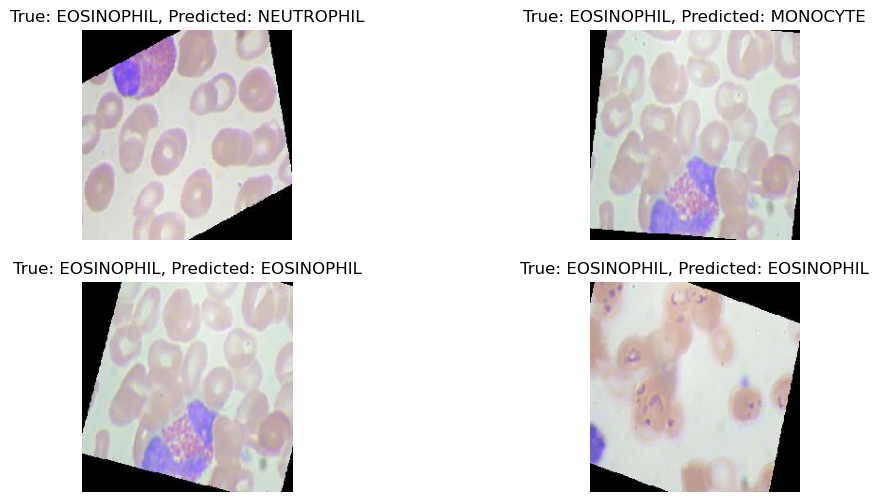

In [28]:
# Loading some test images along with their labels
test_batch = next(test_images)
test_images_array, test_labels = test_batch

# Making predictions
predictions = model.predict(test_images_array)
predicted_labels = np.argmax(predictions, axis=1)

# Get the total number of test images
num_test_images = len(test_images_array)

# Choose 4 random indices
random_indices = np.random.choice(num_test_images, size=4, replace=False)

# Displaying 4 randomly selected images with predictions
plt.figure(figsize=(12, 6))

for i, random_index in enumerate(random_indices):
    plt.subplot(2, 2, i + 1)
    plt.imshow(test_images_array[random_index] / 255.0)  # Assuming images are normalized
    plt.title(f"True: {CLASS_NAMES[np.argmax(test_labels[random_index])]}, Predicted: {CLASS_NAMES[predicted_labels[random_index]]}")
    plt.axis('off')

plt.show()

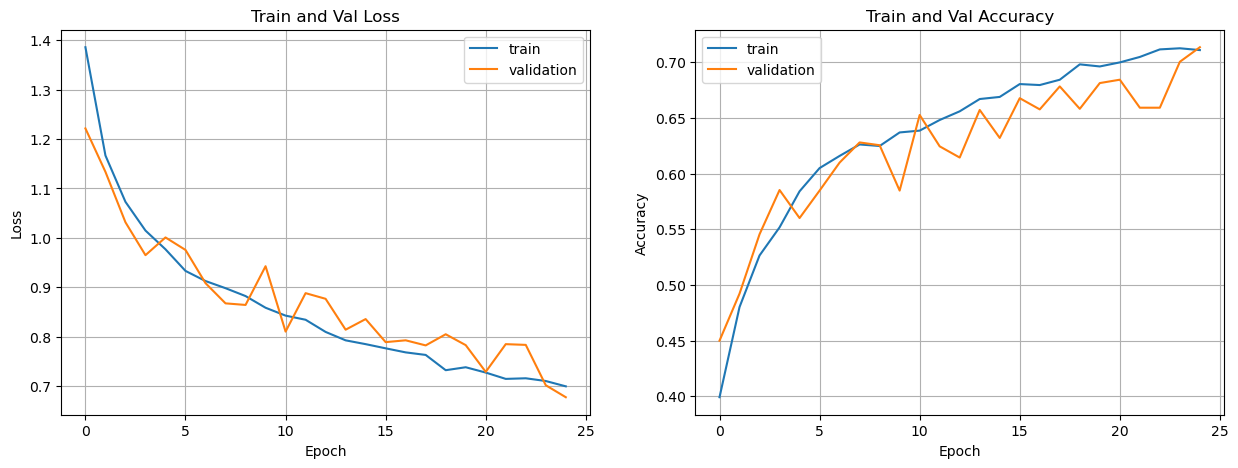

In [50]:
def plot_history(history):
    # expecting history object not dict
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # loss (train & val)
    ax[0].plot(history.history['loss'], label='train')
    ax[0].plot(history.history['val_loss'], label='validation')
    ax[0].set_title('Train and Val Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True)

    # accuracy (train & val)
    ax[1].plot(history.history['accuracy'], label='train')
    ax[1].plot(history.history['val_accuracy'], label='validation')
    ax[1].set_title('Train and Val Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True)
    plt.show()

plot_history(history)

In [34]:
def save_history(history, path):
    pickle.dump(history, open(path, 'wb'))

In [38]:
save_history(history, "history.pkl")

In [33]:
model.save('model.h5')

### VGG

In [39]:
vgg = vgg16.VGG16(weights='imagenet',include_top=False, input_shape=(244,244,3))

In [40]:
vgg.trainable = False

In [41]:
model = models.Sequential()
# Adding the vgg convolutional base model
model.add(vgg)
 
# Adding new layers
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32, activation='relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_1 (Bat  (None, 25088)             100352    
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 32)                802848    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_2 (Bat  (None, 32)                128       
 chNormalization)                                     

In [42]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
history2 = model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=4,
            restore_best_weights=True
        )
    ]
)

Epoch 1/25
249/249 [==============================] - 542s 2s/step - loss: 1.3727 - accuracy: 0.3863 - val_loss: 0.9313 - val_accuracy: 0.6275
Epoch 2/25
249/249 [==============================] - 556s 2s/step - loss: 0.9949 - accuracy: 0.5852 - val_loss: 0.6128 - val_accuracy: 0.8059
Epoch 3/25
249/249 [==============================] - 620s 2s/step - loss: 0.7792 - accuracy: 0.6992 - val_loss: 0.4651 - val_accuracy: 0.8557
Epoch 4/25
249/249 [==============================] - 574s 2s/step - loss: 0.6505 - accuracy: 0.7500 - val_loss: 0.3492 - val_accuracy: 0.8894
Epoch 5/25
249/249 [==============================] - 608s 2s/step - loss: 0.5639 - accuracy: 0.7927 - val_loss: 0.3146 - val_accuracy: 0.8909
Epoch 6/25
249/249 [==============================] - 687s 3s/step - loss: 0.4904 - accuracy: 0.8261 - val_loss: 0.2571 - val_accuracy: 0.9095
Epoch 7/25
249/249 [==============================] - 859s 3s/step - loss: 0.4388 - accuracy: 0.8401 - val_loss: 0.2153 - val_accuracy: 0.9271

In [44]:
CLASS_NAMES = list(train_images.class_indices.keys())
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))
print("Classification Report:\n-----------------------------\n", clr)

78/78 [==============================] - 128s 2s/step
Test Accuracy: 41.777 %
Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.34      0.57      0.43       623
  LYMPHOCYTE       0.66      0.26      0.37       620
    MONOCYTE       0.55      0.18      0.28       620
  NEUTROPHIL       0.41      0.66      0.50       624

    accuracy                           0.42      2487
   macro avg       0.49      0.42      0.39      2487
weighted avg       0.49      0.42      0.39      2487



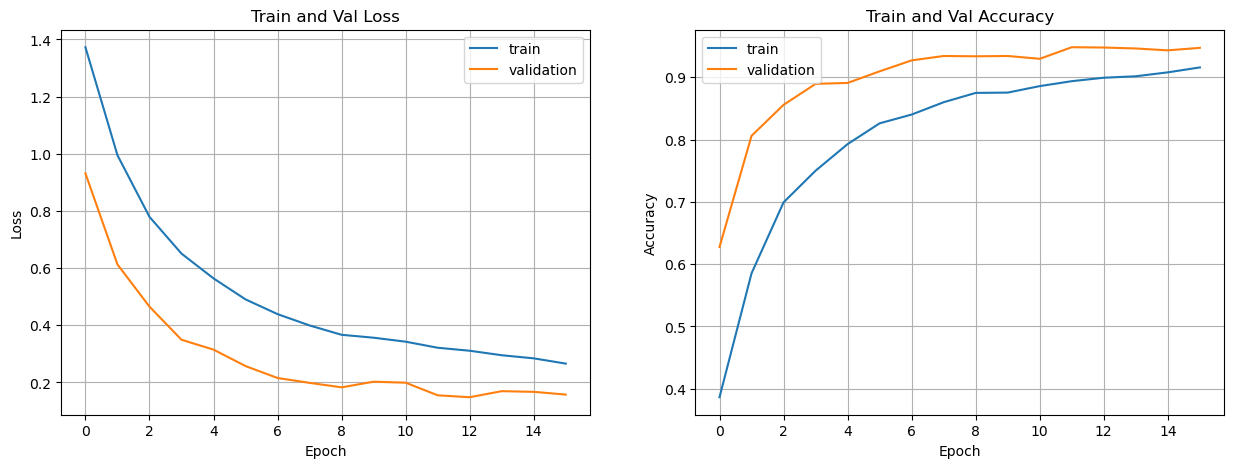

In [51]:
plot_history(history2)

In [52]:
save_history(history2, "history2.pkl")

In [53]:
model.save('model2.h5')

### Resnet

In [54]:
resnet = ResNet50(include_top=False, weights="imagenet", input_shape=(244,244,3))

In [55]:
for layer in resnet.layers[:140]:
    layer.trainable = False

In [56]:
model = models.Sequential()

model.add(resnet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(4,activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 14986244 (57.17 MB)
Non-trainable params: 8609664 (32.84 MB)
_________________________________________________________________


In [57]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
history3 = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=4,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
249/249 [==============================] - 615s 2s/step - loss: 0.2720 - accuracy: 0.8986 - val_loss: 0.2420 - val_accuracy: 0.9326
Epoch 2/20
249/249 [==============================] - 538s 2s/step - loss: 0.0706 - accuracy: 0.9794 - val_loss: 0.4376 - val_accuracy: 0.9005
Epoch 3/20
249/249 [==============================] - 541s 2s/step - loss: 0.0405 - accuracy: 0.9869 - val_loss: 0.1173 - val_accuracy: 0.9618
Epoch 4/20
249/249 [==============================] - 550s 2s/step - loss: 0.0250 - accuracy: 0.9931 - val_loss: 0.1227 - val_accuracy: 0.9663
Epoch 5/20
249/249 [==============================] - 556s 2s/step - loss: 0.0212 - accuracy: 0.9926 - val_loss: 0.0220 - val_accuracy: 0.9899
Epoch 6/20
249/249 [==============================] - 559s 2s/step - loss: 0.0235 - accuracy: 0.9926 - val_loss: 0.0206 - val_accuracy: 0.9925
Epoch 7/20
249/249 [==============================] - 561s 2s/step - loss: 0.0160 - accuracy: 0.9959 - val_loss: 0.0925 - val_accuracy: 0.9769

In [59]:
CLASS_NAMES = list(train_images.class_indices.keys())
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))
print("Classification Report:\n-----------------------------\n", clr)

78/78 [==============================] - 85s 1s/step
Test Accuracy: 84.077 %
Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.71      0.80      0.76       623
  LYMPHOCYTE       1.00      0.99      1.00       620
    MONOCYTE       1.00      0.64      0.78       620
  NEUTROPHIL       0.75      0.92      0.83       624

    accuracy                           0.84      2487
   macro avg       0.86      0.84      0.84      2487
weighted avg       0.86      0.84      0.84      2487



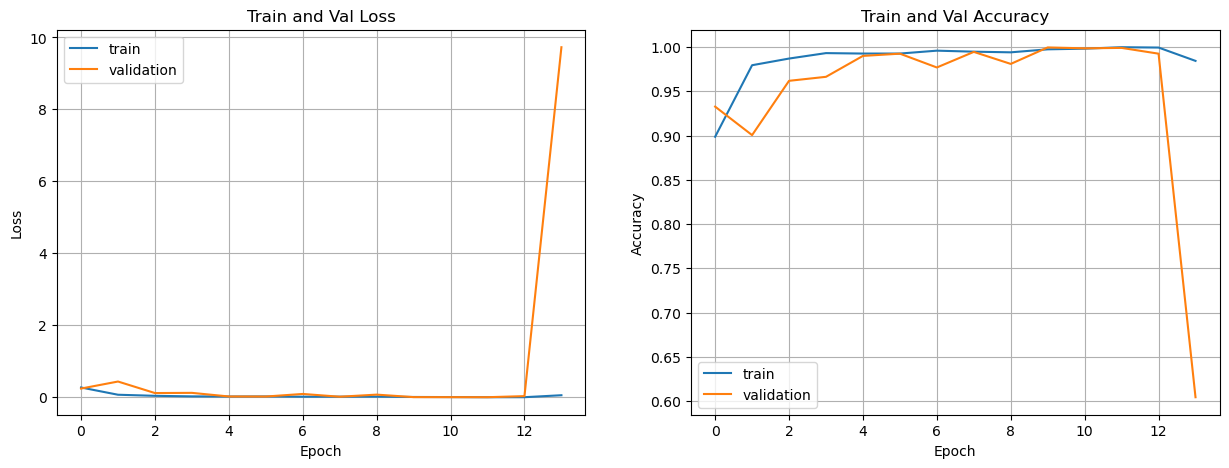

In [60]:
plot_history(history3)

In [61]:
save_history(history3, "history3.pkl")

In [62]:
model.save('model3.h5')

In [80]:
# Flowing image data
train_images=train_generator.flow_from_directory(
    directory=train_path,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_generator.flow_from_directory(
    directory=train_path,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images=test_generator.flow_from_directory(
    directory=test_path,
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


### Resnet with original image size

In [81]:
resnet = ResNet50(include_top=False, weights="imagenet", input_shape=(240,320,3))

In [82]:
for layer in resnet.layers[:140]:
    layer.trainable = False

In [83]:
model = models.Sequential()
model.add(layers.Input(shape=(240,320,3)))
model.add(layers.Lambda(tf.keras.applications.resnet50.preprocess_input))
model.add(resnet)
# Adding additional convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(4,activation="softmax"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 240, 320, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 10, 2048)       23587712  
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 8, 128)         2359424   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 4, 128)         0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_4  (None, 128)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 4)                

In [84]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
history4 = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=4,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
249/249 [==============================] - 688s 3s/step - loss: 0.7561 - accuracy: 0.8308 - val_loss: 0.2690 - val_accuracy: 0.9382
Epoch 2/20
249/249 [==============================] - 704s 3s/step - loss: 0.0740 - accuracy: 0.9731 - val_loss: 0.1161 - val_accuracy: 0.9633
Epoch 3/20
249/249 [==============================] - 718s 3s/step - loss: 0.0472 - accuracy: 0.9841 - val_loss: 0.0249 - val_accuracy: 0.9894
Epoch 4/20
249/249 [==============================] - 710s 3s/step - loss: 0.0296 - accuracy: 0.9911 - val_loss: 0.0568 - val_accuracy: 0.9829
Epoch 5/20
249/249 [==============================] - 730s 3s/step - loss: 0.0137 - accuracy: 0.9957 - val_loss: 0.0179 - val_accuracy: 0.9940
Epoch 6/20
249/249 [==============================] - 715s 3s/step - loss: 0.0146 - accuracy: 0.9962 - val_loss: 0.0112 - val_accuracy: 0.9975
Epoch 7/20
249/249 [==============================] - 710s 3s/step - loss: 0.0085 - accuracy: 0.9974 - val_loss: 0.0107 - val_accuracy: 0.9970

In [86]:
CLASS_NAMES = list(train_images.class_indices.keys())
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))
print("Classification Report:\n-----------------------------\n", clr)

78/78 [==============================] - 110s 1s/step
Test Accuracy: 81.423 %
Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.84      0.77      0.80       623
  LYMPHOCYTE       1.00      0.97      0.98       620
    MONOCYTE       1.00      0.62      0.76       620
  NEUTROPHIL       0.60      0.90      0.72       624

    accuracy                           0.81      2487
   macro avg       0.86      0.81      0.82      2487
weighted avg       0.86      0.81      0.82      2487



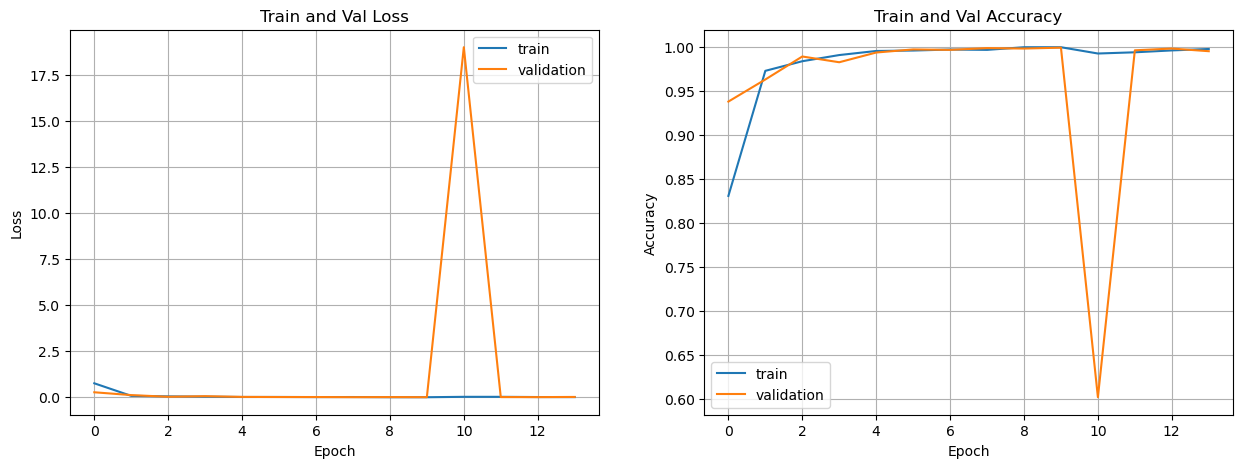

In [87]:
plot_history(history4)

In [88]:
save_history(history4, "history4.pkl")

In [89]:
model.save('model4.h5')

### Resnet without additional convolutional layer

In [90]:
model = models.Sequential()
model.add(layers.Input(shape=(240,320,3)))
model.add(layers.Lambda(tf.keras.applications.resnet50.preprocess_input))
model.add(resnet)
model.add(GlobalAveragePooling2D())
model.add(Dense(4,activation="softmax"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 240, 320, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 10, 2048)       23587712  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 14986244 (57.17 MB)
Non-trainable params: 8609664 (32.84 MB)
_________________________________________________________________


In [91]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [92]:
history5 = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=4,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
249/249 [==============================] - 679s 3s/step - loss: 0.1059 - accuracy: 0.9623 - val_loss: 0.0194 - val_accuracy: 0.9955
Epoch 2/20
249/249 [==============================] - 676s 3s/step - loss: 0.0273 - accuracy: 0.9921 - val_loss: 0.0902 - val_accuracy: 0.9729
Epoch 3/20
249/249 [==============================] - 682s 3s/step - loss: 0.0171 - accuracy: 0.9941 - val_loss: 0.0059 - val_accuracy: 0.9985
Epoch 4/20
249/249 [==============================] - 683s 3s/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.0068 - val_accuracy: 0.9980
Epoch 5/20
249/249 [==============================] - 684s 3s/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 6/20
249/249 [==============================] - 683s 3s/step - loss: 0.0057 - accuracy: 0.9981 - val_loss: 0.0207 - val_accuracy: 0.9925
Epoch 7/20
249/249 [==============================] - 681s 3s/step - loss: 0.0139 - accuracy: 0.9952 - val_loss: 0.0631 - val_accuracy: 0.9769

In [98]:
CLASS_NAMES = list(train_images.class_indices.keys())
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))
print("Classification Report:\n-----------------------------\n", clr)

78/78 [==============================] - 105s 1s/step
Test Accuracy: 87.616 %
Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.85      0.84      0.84       623
  LYMPHOCYTE       1.00      1.00      1.00       620
    MONOCYTE       0.99      0.74      0.85       620
  NEUTROPHIL       0.74      0.93      0.82       624

    accuracy                           0.88      2487
   macro avg       0.89      0.88      0.88      2487
weighted avg       0.89      0.88      0.88      2487



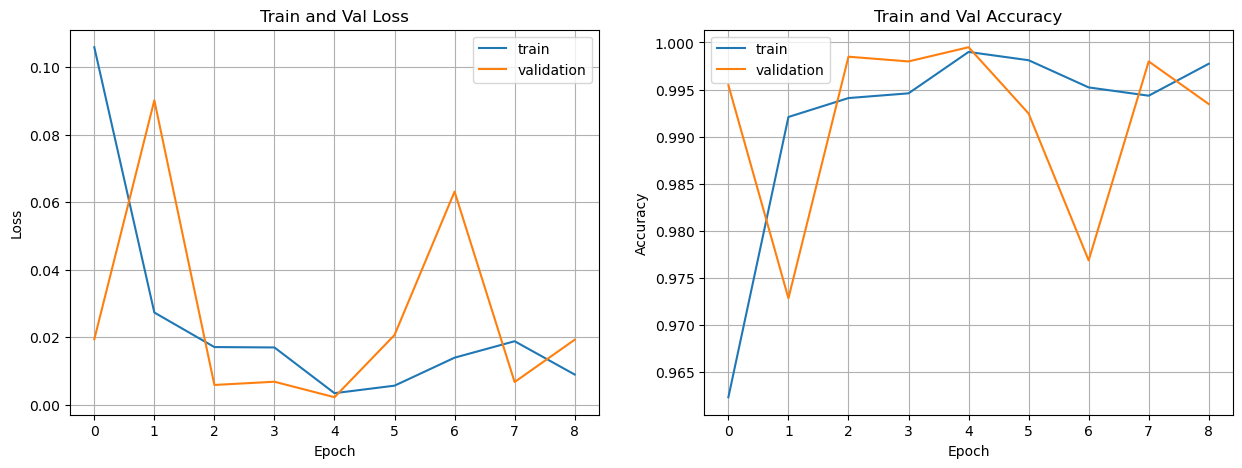

In [94]:
plot_history(history5)

In [95]:
save_history(history5, "history5.pkl")

In [96]:
model.save('model5.h5')

#### Highest Test Accuracy: 87.616 %

In [42]:
# Extracting features and labels from the generator
X_train, y_train = train_images.next()
X_val, y_val = val_images.next()
X_test, y_test = test_images.next()

In [43]:
# Reshaping the image data to fit into the RandomForestClassifier
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

### Random Forest

In [44]:
# Initializing the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [45]:
# Training the model on the training data
rf_model.fit(X_train, np.argmax(y_train, axis=1))

RandomForestClassifier(random_state=42)

In [46]:
# Predictions on the validation set
y_val_pred = rf_model.predict(X_val)

In [47]:
# Evaluating the model on the validation set
accuracy = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

Validation Accuracy: 0.22


In [48]:
# Predicting and Evaluating the model on the test set
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.09


In [49]:
# Additional evaluation metrics
print("\nClassification Report:")
print(classification_report(np.argmax(y_val, axis=1), y_val_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.12      0.20         8
           1       0.00      0.00      0.00         7
           2       0.15      0.25      0.19         8
           3       0.24      0.44      0.31         9

    accuracy                           0.22        32
   macro avg       0.22      0.20      0.17        32
weighted avg       0.23      0.22      0.18        32



### KNN

In [69]:
# Initializing the KNeighborsClassifier with the desired number of neighbors (adjust as needed)
knn_model = KNeighborsClassifier(n_neighbors=3)

In [70]:
# Training the model on the training data
knn_model.fit(X_train, np.argmax(y_train, axis=1))

KNeighborsClassifier(n_neighbors=3)

In [71]:
# Predictions on the validation set
y_val_pred = knn_model.predict(X_val)

# Evaluating the model on the validation set
accuracy = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

Validation Accuracy: 0.28


In [72]:
# Predicting and Evaluating the model on the test set
y_test_pred = knn_model.predict(X_test)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.38


In [54]:
# Additional evaluation metrics
print("\nClassification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.38      0.55        32
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.38        32
   macro avg       0.25      0.09      0.14        32
weighted avg       1.00      0.38      0.55        32



### SVM

In [55]:
# Initializing the SVM model
svm_model = SVC(kernel='linear', C=1.0)

In [56]:
# Training the model on the training data
svm_model.fit(X_train, np.argmax(y_train, axis=1))

SVC(kernel='linear')

In [57]:
# Predictions on the validation set
y_val_pred = svm_model.predict(X_val)

# Evaluating the model on the validation set
accuracy = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

Validation Accuracy: 0.28


In [58]:
# Predicting and Evaluating the model on the test set
y_test_pred = svm_model.predict(X_test)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.31


In [59]:
# Additional evaluation metrics
print("\nClassification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.31      0.48        32
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.31        32
   macro avg       0.33      0.10      0.16        32
weighted avg       1.00      0.31      0.48        32



### XGBoost

In [60]:
# Initializing the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(np.argmax(y_train, axis=1))))

In [61]:
# Training the model on the training data
xgb_model.fit(X_train, np.argmax(y_train, axis=1))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [62]:
# Predictions on the validation set
y_val_pred = xgb_model.predict(X_val)

# Evaluating the model on the validation set
accuracy = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

Validation Accuracy: 0.47


In [63]:
# Predicting and Evaluating the model on the test set
y_test_pred = xgb_model.predict(X_test)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.31


In [64]:
# Additional evaluation metrics
print("\nClassification Report:")
print(classification_report(np.argmax(y_val, axis=1), y_val_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       1.00      0.29      0.44         7
           2       0.33      0.38      0.35         8
           3       0.36      0.56      0.43         9

    accuracy                           0.47        32
   macro avg       0.60      0.46      0.47        32
weighted avg       0.58      0.47      0.47        32



Random forest, SVM, KNN and XGBoost are performed using original image size.